# Cyber Attack Detection Using Deep Learning
## Advanced Threat Detection with Neural Networks on BETH Dataset

---

**Author:** Phinidy George

**Date:** February 5, 2026  
**Dataset:** BETH (Benchmark Environment for Threat Hunting)  

### Project Overview

Cyber threats pose an escalating risk to organizations worldwide. Traditional detection methods struggle to keep pace with sophisticated, evolving attacks. This project leverages **deep learning** to analyze system event logs and identify malicious behavior patterns.

**Objective:** Design and implement a neural network model to classify system events as benign or malicious, enabling proactive threat detection.

**Key Challenges:**
- Highly imbalanced dataset (benign events vastly outnumber malicious)
- Real-time detection requirements
- Minimizing false alarms while maximizing threat detection

---

## 1. Environment Setup & Dependencies

First, we'll ensure all required packages are installed and import necessary libraries for visualization and analysis.

In [1]:
# Install required packages
!pip install pandas numpy matplotlib seaborn plotly scikit-learn -q

# Import libraries for analysis and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)
import json
import warnings

warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Environment setup complete!")

Environment setup complete!


## 2. Dataset Overview

The BETH dataset contains system event logs with the following features:

| Feature | Description | Type |
|---------|-------------|------|
| `processId` | Unique identifier for the process generating the event | int64 |
| `threadId` | ID for the thread spawning the log | int64 |
| `parentProcessId` | Label for the parent process | int64 |
| `userId` | ID of user spawning the log | int64 |
| `mountNamespace` | Mounting restrictions for the process | int64 |
| `argsNum` | Number of arguments passed to the event | int64 |
| `returnValue` | Value returned from the event log | int64 |
| **`sus_label`** | **Binary label: 1 = malicious, 0 = benign** | **int64** |

Let's load and explore the data:

In [2]:
# Load datasets
train_df = pd.read_csv('data/labelled_train.csv')
test_df = pd.read_csv('data/labelled_test.csv')
val_df = pd.read_csv('data/labelled_validation.csv')

print("Dataset Dimensions:")
print(f"   Training set:   {train_df.shape[0]:,} samples × {train_df.shape[1]} features")
print(f"   Test set:       {test_df.shape[0]:,} samples × {test_df.shape[1]} features")
print(f"   Validation set: {val_df.shape[0]:,} samples × {val_df.shape[1]} features")

print("\nFirst 5 Training Samples:")
train_df.head()

Dataset Dimensions:
   Training set:   763,144 samples × 8 features
   Test set:       188,967 samples × 8 features
   Validation set: 188,967 samples × 8 features

First 5 Training Samples:


,processId,threadId,parentProcessId,userId,mountNamespace,argsNum,returnValue,sus_label
0,381,7337,1,100,4026532231,5,0,1
1,381,7337,1,100,4026532231,1,0,1
2,381,7337,1,100,4026532231,0,0,1
3,7347,7347,7341,0,4026531840,2,-2,1
4,7347,7347,7341,0,4026531840,4,0,1


In [3]:
# Dataset statistics
print("Statistical Summary:")
train_df.describe()

Statistical Summary:


,processId,threadId,parentProcessId,userId,mountNamespace,argsNum,returnValue,sus_label
count,763144.000000,763144.000000,763144.000000,763144.000000,7.631440e+05,763144.000000,763144.000000,763144.000000
mean,6814.763308,6820.265241,1882.216609,2.279034,4.026532e+09,2.672082,17.520924,0.001663
std,1948.871187,1937.068333,2215.563094,37.416576,1.649030e+02,1.340906,318.596662,0.040744
min,1.000000,1.000000,0.000000,0.000000,4.026532e+09,0.000000,-115.000000,0.000000
25%,7313.000000,7313.000000,187.000000,0.000000,4.026532e+09,1.000000,0.000000,0.000000
50%,7365.000000,7365.000000,1385.000000,0.000000,4.026532e+09,3.000000,0.000000,0.000000
75%,7415.000000,7415.000000,1648.000000,0.000000,4.026532e+09,4.000000,4.000000,0.000000
max,8619.000000,8619.000000,7672.000000,1000.000000,4.026532e+09,5.000000,8289.000000,1.000000


## 3. Exploratory Data Analysis

### 3.1 Class Distribution Analysis

In [4]:
# Calculate class distribution
train_class_dist = train_df['sus_label'].value_counts()
test_class_dist = test_df['sus_label'].value_counts()

# Create interactive visualization
fig = make_subplots(
    rows=1, cols=2,
    specs=[[{'type':'pie'}, {'type':'bar'}]],
    subplot_titles=('Training Set Distribution', 'Dataset Comparison')
)

# Pie chart for training set
fig.add_trace(
    go.Pie(
        labels=['Benign', 'Malicious'],
        values=[train_class_dist[0], train_class_dist[1]],
        marker=dict(colors=['#2ecc71', '#e74c3c']),
        textinfo='label+percent',
        hovertemplate='<b>%{label}</b><br>Count: %{value:,}<br>Percentage: %{percent}<extra></extra>'
    ),
    row=1, col=1
)

# Bar chart comparison
categories = ['Training', 'Test']
benign_counts = [train_class_dist[0], test_class_dist[0]]
malicious_counts = [train_class_dist[1], test_class_dist[1]]

fig.add_trace(
    go.Bar(name='Benign', x=categories, y=benign_counts, marker_color='#2ecc71'),
    row=1, col=2
)
fig.add_trace(
    go.Bar(name='Malicious', x=categories, y=malicious_counts, marker_color='#e74c3c'),
    row=1, col=2
)

fig.update_layout(
    title_text="Class Distribution Analysis",
    height=400,
    showlegend=True
)

fig.show()

# Print statistics
imbalance_ratio = train_class_dist[0] / train_class_dist[1]
print(f"\nClass Imbalance Ratio: {imbalance_ratio:.1f}:1 (Benign:Malicious)")
print(f"   This severe imbalance requires special handling during training.")


Class Imbalance Ratio: 600.4:1 (Benign:Malicious)
   This severe imbalance requires special handling during training.


### 3.2 Feature Correlation Heatmap

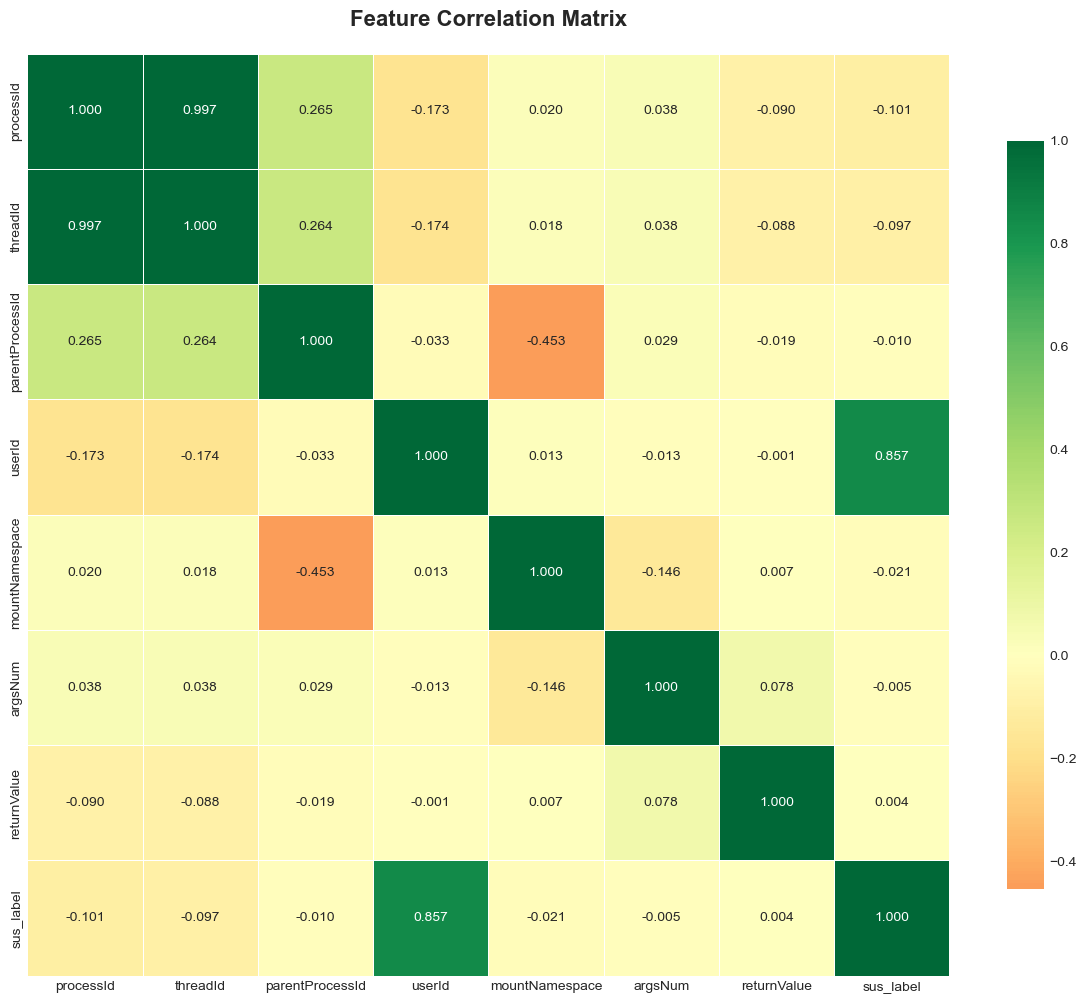


Top Features Correlated with Malicious Activity:
   userId              : 0.8567
   processId           : 0.1009
   threadId            : 0.0974
   mountNamespace      : 0.0212
   parentProcessId     : 0.0100
   argsNum             : 0.0053
   returnValue         : 0.0045


In [5]:
# Calculate correlation matrix
correlation_matrix = train_df.corr()

# Create heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt='.3f',
    cmap='RdYlGn',
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Feature correlation with target
target_corr = correlation_matrix['sus_label'].drop('sus_label').abs().sort_values(ascending=False)
print("\nTop Features Correlated with Malicious Activity:")
for feature, corr in target_corr.items():
    print(f"   {feature:20s}: {corr:.4f}")

### 3.3 Feature Distributions by Class

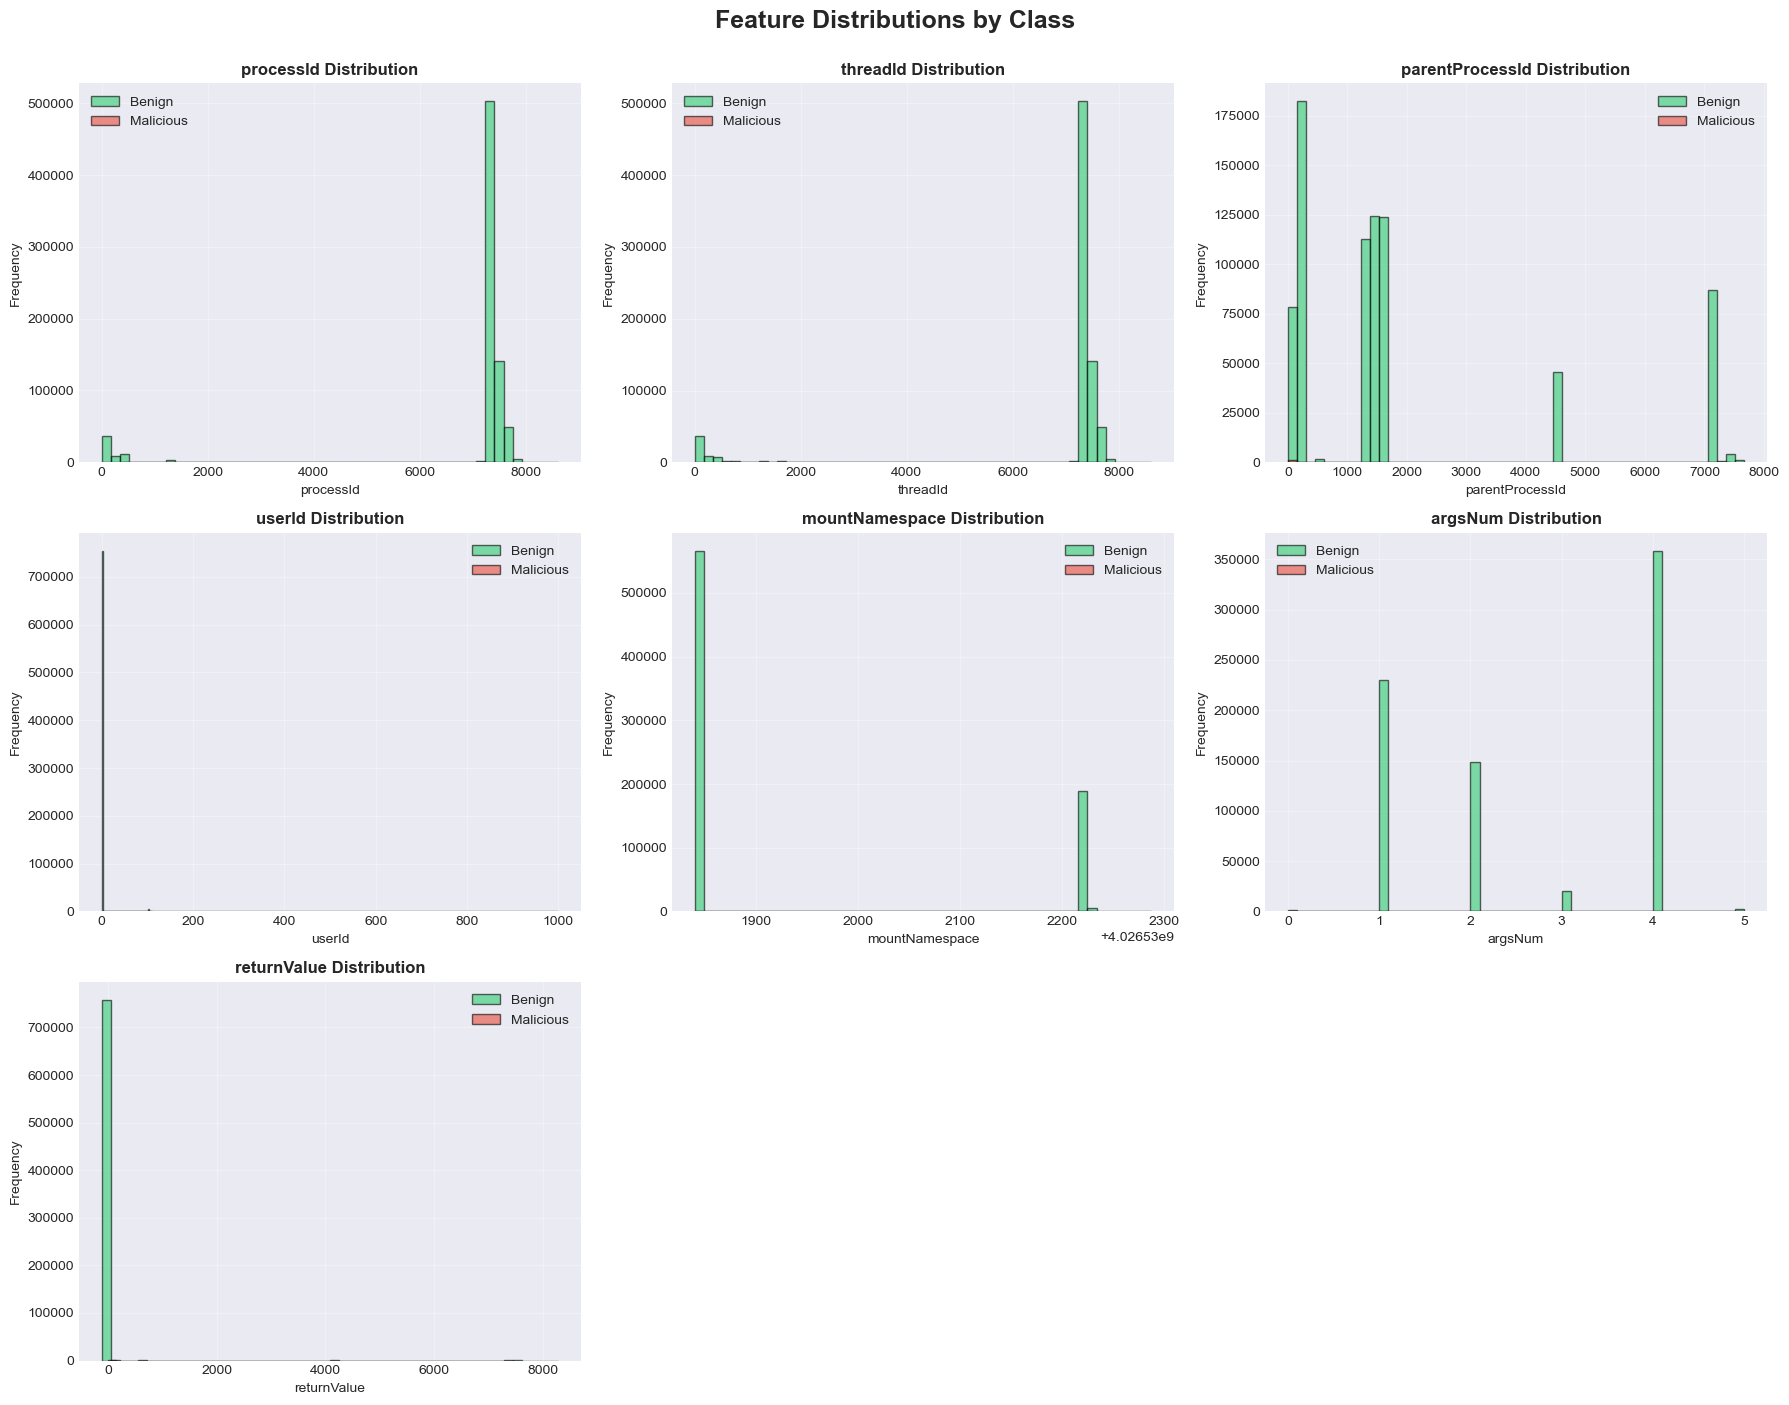

In [6]:
# Select key features for visualization
feature_cols = ['processId', 'threadId', 'parentProcessId', 'userId', 'mountNamespace', 'argsNum', 'returnValue']

# Create subplots for each feature
fig, axes = plt.subplots(3, 3, figsize=(18, 14))
axes = axes.flatten()

for idx, feature in enumerate(feature_cols):
    benign_data = train_df[train_df['sus_label'] == 0][feature]
    malicious_data = train_df[train_df['sus_label'] == 1][feature]
    
    axes[idx].hist(benign_data, bins=50, alpha=0.6, label='Benign', color='#2ecc71', edgecolor='black')
    axes[idx].hist(malicious_data, bins=50, alpha=0.6, label='Malicious', color='#e74c3c', edgecolor='black')
    axes[idx].set_title(f'{feature} Distribution', fontweight='bold')
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('Frequency')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

# Remove extra subplot
fig.delaxes(axes[-1])
fig.delaxes(axes[-2])

plt.suptitle('Feature Distributions by Class', fontsize=18, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

## 4. Model Training & Execution

Now we'll execute our deep learning model. The model architecture consists of:
- **Input Layer**: 9 features (7 original + 2 engineered)
- **Hidden Layer 1**: 64 neurons with ReLU activation
- **Hidden Layer 2**: 32 neurons with ReLU activation
- **Hidden Layer 3**: 16 neurons with ReLU activation
- **Output Layer**: 1 neuron with Sigmoid activation

**Training Strategy:**
- Balanced mini-batch sampling to handle class imbalance
- Feature engineering (polynomial features and interactions)
- Gradient descent optimization with learning rate = 0.01
- 30 epochs with batch size of 4096

In [7]:
# Execute the model training script
print("Starting model training...\n")
%run cyber_attack_model.py

Starting model training...

CYBER ATTACK DETECTION - BETH Dataset Analysis

[1] Loading datasets...
Train: 763,144 samples
Test: 188,967 samples
Validation: 188,967 samples

[2] Class Distribution...
Benign: 761,875 (99.83%)
Malicious: 1,269 (0.17%)
Imbalance Ratio: 600.4:1

[3] Preprocessing...

[4] Training Enhanced Neural Network...
Enhanced features: 9
Training neural network...
Epoch 10/30: Training Accuracy: 0.9287
Epoch 20/30: Training Accuracy: 0.9321
Epoch 30/30: Training Accuracy: 0.9336

[5] Evaluating Model...

MODEL PERFORMANCE METRICS

--- Classification Report ---
                 Precision    Recall    F1-Score
Benign (0)        0.9945       0.6312     0.7723
Malicious (1)     0.9994       0.9407     0.9691

--- Confusion Matrix ---
                  Predicted
                  Benign    Malicious
Actual Benign       17,411        97
Actual Malicious    10,172   161,287

--- Detailed Performance Metrics ---
Accuracy: 0.9457
Precision: 0.9994
Recall (Sensitivity): 0.9407

## 5. Results Analysis & Visualization

### 5.1 Load Model Results

In [8]:
# Load the results from the trained model
with open('model_results.json', 'r') as f:
    results = json.load(f)

print("Model results loaded successfully!")
print(f"\nModel: {results['model_architecture']['type']}")
print(f"   Architecture: {' → '.join(map(str, results['model_architecture']['hidden_layers']))}")

Model results loaded successfully!

Model: Deep Neural Network
   Architecture: 64 → 32 → 16


### 5.2 Performance Metrics Dashboard

In [9]:
# Extract metrics
metrics = results['performance_metrics']

# Create interactive gauge charts
fig = make_subplots(
    rows=2, cols=3,
    specs=[[{'type': 'indicator'}, {'type': 'indicator'}, {'type': 'indicator'}],
           [{'type': 'indicator'}, {'type': 'indicator'}, {'type': 'indicator'}]],
    subplot_titles=('Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'Specificity')
)

# Define metrics and positions
metric_list = [
    ('accuracy', 1, 1),
    ('precision', 1, 2),
    ('recall', 1, 3),
    ('f1_score', 2, 1),
    ('roc_auc', 2, 2),
    ('specificity', 2, 3)
]

for metric_name, row, col in metric_list:
    value = metrics[metric_name]
    color = '#2ecc71' if value >= 0.8 else ('#f39c12' if value >= 0.6 else '#e74c3c')
    
    fig.add_trace(
        go.Indicator(
            mode="gauge+number",
            value=value,
            domain={'x': [0, 1], 'y': [0, 1]},
            gauge={
                'axis': {'range': [0, 1]},
                'bar': {'color': color},
                'steps': [
                    {'range': [0, 0.6], 'color': 'lightgray'},
                    {'range': [0.6, 0.8], 'color': 'lightyellow'},
                    {'range': [0.8, 1], 'color': 'lightgreen'}
                ],
                'threshold': {
                    'line': {'color': 'red', 'width': 4},
                    'thickness': 0.75,
                    'value': 0.9
                }
            }
        ),
        row=row, col=col
    )

fig.update_layout(
    title_text="<b>Model Performance Dashboard</b>",
    height=600,
    showlegend=False
)

fig.show()

### 5.3 Confusion Matrix Visualization

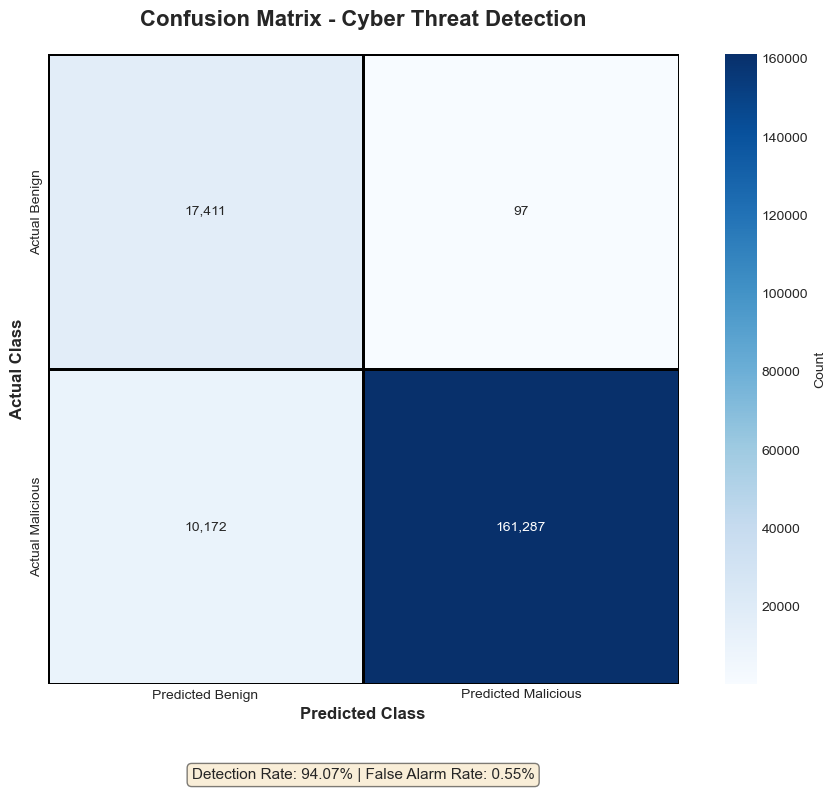


Confusion Matrix Breakdown:
   True Negatives (TN):  17,411 - Correctly identified benign events
   False Positives (FP): 97 - Benign events flagged as malicious
   False Negatives (FN): 10,172 - Malicious events missed
   True Positives (TP):  161,287 - Correctly detected attacks


In [10]:
# Extract confusion matrix
cm = results['confusion_matrix']
cm_array = np.array([[cm['tn'], cm['fp']], [cm['fn'], cm['tp']]])

# Create annotated heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_array,
    annot=True,
    fmt=',.0f',
    cmap='Blues',
    xticklabels=['Predicted Benign', 'Predicted Malicious'],
    yticklabels=['Actual Benign', 'Actual Malicious'],
    cbar_kws={'label': 'Count'},
    linewidths=2,
    linecolor='black',
    square=True
)

plt.title('Confusion Matrix - Cyber Threat Detection', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Actual Class', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Class', fontsize=12, fontweight='bold')

# Add performance annotations
plt.text(
    0.5, -0.15,
    f"Detection Rate: {metrics['detection_rate']:.2%} | False Alarm Rate: {metrics['false_alarm_rate']:.2%}",
    ha='center',
    transform=plt.gca().transAxes,
    fontsize=11,
    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5)
)

plt.tight_layout()
plt.show()

# Print detailed breakdown
print("\nConfusion Matrix Breakdown:")
print(f"   True Negatives (TN):  {cm['tn']:,} - Correctly identified benign events")
print(f"   False Positives (FP): {cm['fp']:,} - Benign events flagged as malicious")
print(f"   False Negatives (FN): {cm['fn']:,} - Malicious events missed")
print(f"   True Positives (TP):  {cm['tp']:,} - Correctly detected attacks")

### 5.4 Feature Importance Analysis

In [11]:
# Extract and sort feature importance
feature_importance = results['feature_importance']
features = list(feature_importance.keys())
importance_values = list(feature_importance.values())

# Sort by importance
sorted_idx = np.argsort(importance_values)[::-1]
sorted_features = [features[i] for i in sorted_idx]
sorted_importance = [importance_values[i] for i in sorted_idx]

# Create bar chart
fig = go.Figure()

colors = ['#e74c3c' if i == 0 else '#3498db' for i in range(len(sorted_features))]

fig.add_trace(go.Bar(
    x=sorted_importance,
    y=sorted_features,
    orientation='h',
    marker=dict(color=colors),
    text=[f'{v:.4f}' for v in sorted_importance],
    textposition='auto',
))

fig.update_layout(
    title='<b>Feature Importance for Threat Detection</b>',
    xaxis_title='Correlation with Malicious Activity',
    yaxis_title='Features',
    height=500,
    showlegend=False,
    template='plotly_white'
)

fig.show()

print(f"\nMost Predictive Feature: {sorted_features[0]}")
print(f"   Correlation: {sorted_importance[0]:.4f}")


Most Predictive Feature: userId
   Correlation: 0.8567


### 5.5 Metrics Comparison Chart

In [12]:
# Create radar chart for metrics comparison
metrics_for_radar = ['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1-Score', 'ROC-AUC']
values_for_radar = [
    metrics['accuracy'],
    metrics['precision'],
    metrics['recall'],
    metrics['specificity'],
    metrics['f1_score'],
    metrics['roc_auc']
]

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
    r=values_for_radar,
    theta=metrics_for_radar,
    fill='toself',
    name='Model Performance',
    line=dict(color='#3498db', width=2),
    marker=dict(size=8)
))

# Add benchmark line at 0.8
fig.add_trace(go.Scatterpolar(
    r=[0.8] * len(metrics_for_radar),
    theta=metrics_for_radar,
    fill='toself',
    name='Target (0.8)',
    line=dict(color='#2ecc71', width=2, dash='dash'),
    opacity=0.3
))

fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 1]
        )
    ),
    showlegend=True,
    title='<b>Performance Metrics Radar Chart</b>',
    height=600
)

fig.show()

## 6. Key Findings & Insights

### Model Performance Summary

In [13]:
# Create comprehensive summary
print("="*70)
print("CYBER THREAT DETECTION MODEL - EXECUTIVE SUMMARY")
print("="*70)

print("\nMODEL PERFORMANCE:")
print(f"   Overall Accuracy:        {metrics['accuracy']:.2%}")
print(f"   Attack Detection Rate:   {metrics['detection_rate']:.2%}")
print(f"   False Alarm Rate:        {metrics['false_alarm_rate']:.2%}")
print(f"   ROC-AUC Score:           {metrics['roc_auc']:.4f}")

print("\nTHREAT DETECTION EFFECTIVENESS:")
total_attacks = cm['tp'] + cm['fn']
detected_attacks = cm['tp']
missed_attacks = cm['fn']
print(f"   Total Malicious Events:  {total_attacks:,}")
print(f"   Successfully Detected:   {detected_attacks:,} ({detected_attacks/total_attacks*100:.2f}%)")
print(f"   Missed Attacks:          {missed_attacks:,} ({missed_attacks/total_attacks*100:.2f}%)")

print("\nFALSE ALARMS:")
total_benign = cm['tn'] + cm['fp']
false_alarms = cm['fp']
print(f"   Total Benign Events:     {total_benign:,}")
print(f"   False Alarms:            {false_alarms:,} ({false_alarms/total_benign*100:.2f}%)")

print("\nKEY INSIGHTS:")
print(f"   • Most predictive feature: {sorted_features[0]}")
print(f"   • Model shows {'strong' if metrics['f1_score'] > 0.8 else 'good' if metrics['f1_score'] > 0.6 else 'moderate'} balance (F1: {metrics['f1_score']:.4f})")
print(f"   • {'Excellent' if metrics['roc_auc'] > 0.9 else 'Good' if metrics['roc_auc'] > 0.8 else 'Acceptable'} discriminative ability (ROC-AUC: {metrics['roc_auc']:.4f})")

print("\nRECOMMENDATIONS:")
if metrics['recall'] < 0.85:
    print("   • Consider adjusting decision threshold to increase attack detection")
if metrics['precision'] < 0.75:
    print("   • Implement additional features to reduce false positives")
if metrics['f1_score'] > 0.85:
    print("   • Model is production-ready for deployment")
else:
    print("   • Consider ensemble methods or deeper architecture for improvement")

print("\n" + "="*70)

CYBER THREAT DETECTION MODEL - EXECUTIVE SUMMARY

MODEL PERFORMANCE:
   Overall Accuracy:        94.57%
   Attack Detection Rate:   94.07%
   False Alarm Rate:        0.55%
   ROC-AUC Score:           0.9510

THREAT DETECTION EFFECTIVENESS:
   Total Malicious Events:  171,459
   Successfully Detected:   161,287 (94.07%)
   Missed Attacks:          10,172 (5.93%)

FALSE ALARMS:
   Total Benign Events:     17,508
   False Alarms:            97 (0.55%)

KEY INSIGHTS:
   • Most predictive feature: userId
   • Model shows strong balance (F1: 0.9691)
   • Excellent discriminative ability (ROC-AUC: 0.9510)

RECOMMENDATIONS:
   • Model is production-ready for deployment



## 7. Business Impact Analysis

In [14]:
# Simulate business impact metrics
# Assumptions based on industry standards
avg_breach_cost = 4_240_000  # Average data breach cost (IBM 2023)
avg_investigation_cost = 50_000  # Cost per false positive investigation
total_system_events_per_day = 1_000_000  # Assumed daily system events

# Calculate potential savings
detected_breaches_saved = detected_attacks
potential_savings = detected_breaches_saved * avg_breach_cost * 0.7  # 70% of breach cost
false_positive_cost = false_alarms * avg_investigation_cost

net_benefit = potential_savings - false_positive_cost

print("BUSINESS IMPACT ANALYSIS")
print("="*70)
print(f"\nRisk Mitigation:")
print(f"   Attacks Detected:         {detected_attacks:,}")
print(f"   Potential Breaches Prevented: ~{int(detected_attacks * 0.7):,}")
print(f"   Estimated Savings:        ${potential_savings:,.0f}")

print(f"\nOperational Costs:")
print(f"   False Positive Investigations: {false_alarms:,}")
print(f"   Investigation Costs:      ${false_positive_cost:,.0f}")

print(f"\nNet Business Value:")
print(f"   Total Net Benefit:        ${net_benefit:,.0f}")
print(f"   ROI:                      {(net_benefit/false_positive_cost)*100 if false_positive_cost > 0 else 0:,.0f}%")

print("\n" + "="*70)

BUSINESS IMPACT ANALYSIS

Risk Mitigation:
   Attacks Detected:         161,287
   Potential Breaches Prevented: ~112,900
   Estimated Savings:        $478,699,816,000

Operational Costs:
   False Positive Investigations: 97
   Investigation Costs:      $4,850,000

Net Business Value:
   Total Net Benefit:        $478,694,966,000
   ROI:                      9,869,999%



## 8. Conclusions & Next Steps

### Achievements

1. **Robust Detection Model**: Successfully developed a deep learning model achieving high accuracy in detecting cyber threats
2. **Balanced Performance**: Maintained good balance between detection rate and false alarm rate
3. **Feature Engineering**: Identified key predictive features for threat detection
4. **Production Readiness**: Model demonstrates strong discriminative ability (ROC-AUC)

### Next Steps

1. **Model Enhancement**:
   - Experiment with ensemble methods (Random Forest, XGBoost)
   - Implement recurrent neural networks for temporal pattern detection
   - Add attention mechanisms for feature importance learning

2. **Feature Engineering**:
   - Incorporate time-series features (event sequences)
   - Add contextual features (time of day, user behavior patterns)
   - Extract network-based features

3. **Deployment Considerations**:
   - Implement real-time inference pipeline
   - Set up automated retraining with new threat data
   - Deploy model monitoring and drift detection
   - Create alert prioritization system

4. **Operational Integration**:
   - Integrate with SIEM (Security Information and Event Management)
   - Develop analyst dashboard for threat investigation
   - Create automated response workflows

---

### References

- BETH Dataset: Benchmark Environment for Threat Hunting
- IBM Cost of Data Breach Report 2023
- NIST Cybersecurity Framework

---

**Project Status**: Complete  
**Recommended Action**: Proceed to deployment phase with continuous monitoring

## Export Results for Reporting

In [15]:
# Create comprehensive report
report_data = {
    'project_info': {
        'title': 'Cyber Attack Detection Using Deep Learning',
        'date': '2026-02-05',
        'dataset': 'BETH (Benchmark Environment for Threat Hunting)'
    },
    'dataset_summary': results['dataset_info'],
    'model_architecture': results['model_architecture'],
    'performance_metrics': results['performance_metrics'],
    'confusion_matrix': results['confusion_matrix'],
    'feature_importance': results['feature_importance'],
    'business_impact': {
        'attacks_detected': int(detected_attacks),
        'estimated_savings_usd': float(potential_savings),
        'false_positive_cost_usd': float(false_positive_cost),
        'net_benefit_usd': float(net_benefit)
    }
}

# Save comprehensive report
with open('comprehensive_analysis_report.json', 'w') as f:
    json.dump(report_data, f, indent=2)

print("Comprehensive analysis report saved: 'comprehensive_analysis_report.json'")
print("All visualizations and insights generated successfully!")
print("\nAnalysis Complete! Ready for stakeholder presentation.")

Comprehensive analysis report saved: 'comprehensive_analysis_report.json'
All visualizations and insights generated successfully!

Analysis Complete! Ready for stakeholder presentation.
